In [1]:
# Basic libraries
import pandas as pd
import matplotlib.pyplot as plt

# Classification models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Utilities and metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Exploração do Dataset

In [2]:
path = "../data/multiclass/"
df = pd.read_csv(path + "ecommerceDataset.csv", header=None)
df.dropna(inplace=True)
df = df.rename(columns={0: 'category', 1: 'description'})

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     50425 non-null  object
 1   description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


## Preprocessamento do Dataset

In [4]:
df = df.groupby('category').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)
df['category'].value_counts()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_3448\3079697357.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('category').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)


category
Household                 1931
Books                     1182
Electronics               1062
Clothing & Accessories     867
Name: count, dtype: int64

## Divisão do Dataset em treino e teste

In [5]:
features = df['description']
target = df['category']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=421)

## Definição dos vetorizadores, modelos e parâmetros para o GridSearch

In [6]:
vectorizers = [
    TfidfVectorizer(),
    CountVectorizer()
]

param_grids = [
    {
        'vectorizer': vectorizers,
        'classifier': [SVC()],
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'vectorizer': vectorizers,
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.01, 1.0]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [1, 10],
        'classifier__penalty': ['l2']
    },
    {
        'vectorizer': vectorizers,
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20]
    }
]

pipeline = Pipeline([
    ('vectorizer', 'passthrough'),
    ('classifier', 'passthrough')
])

## Execução do GridSearch

In [7]:
grid_search = GridSearchCV(pipeline, param_grids, cv=5, n_jobs=4, verbose=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', 'passthrough'),
                                       ('classifier', 'passthrough')]),
             n_jobs=4,
             param_grid=[{'classifier': [SVC()], 'classifier__C': [1, 10],
                          'classifier__kernel': ['linear', 'rbf'],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.01, 1.0],
                          'vectorizer': [TfidfVectoriz...
                          'classifier__penalty': ['l2'],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [3, 5, 7],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [DecisionTreeClassifier()],
                          'classifier__max_depth': [None, 10, 20],
                          'vectorizer': [TfidfVectorizer(),
                                         CountVectorizer()]}],
             scoring='accuracy', verbose=3)

## Resultados finais e matriz de confusão

In [8]:
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest set classification report with best model:")
print(classification_report(y_test, y_pred, digits=4))

Best parameters found: {'classifier': SVC(), 'classifier__C': 10, 'classifier__kernel': 'linear', 'vectorizer': TfidfVectorizer()}
Best cross-validation score: 0.947432976345316

Test set classification report with best model:
                        precision    recall  f1-score   support

                 Books     0.9644    0.9394    0.9518       231
Clothing & Accessories     0.9870    0.9560    0.9712       159
           Electronics     0.9543    0.9248    0.9393       226
             Household     0.9367    0.9796    0.9577       393

              accuracy                         0.9544      1009
             macro avg     0.9606    0.9499    0.9550      1009
          weighted avg     0.9549    0.9544    0.9544      1009



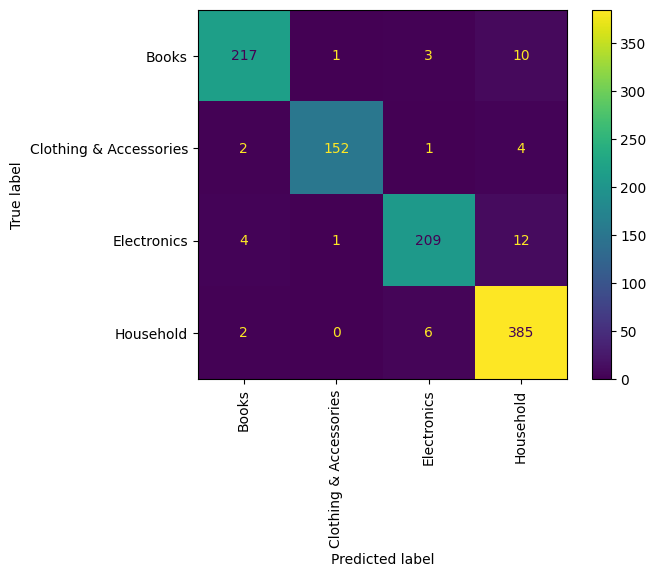

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='viridis', xticks_rotation='vertical')